In [29]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Open Sans']
# rcParams['font.weight'] = 'semibold'

haec_h = (0 / 256.0, 113 / 256.0, 157 / 256.0)
haec_a = (14 / 256.0, 180 / 256.0, 142 / 256.0)
haec_e = (138 / 256.0, 200 / 256.0, 101 / 256.0)
haec_c = (178 / 256.0, 210 / 256.0, 51 / 256.0)

seed_to_plot = 11
max_time = 50
runs = [0,1,2]

In [71]:
def read_measurements(file_name):
    data = pd.read_csv(file_name, delimiter=';')
                       #, skip_header=0,
                       #  names=('Tool', 'Model', 'RunIndex', 'PhaseName', 'MetricName', 'MetricValue'))
                         #dtype=(string,str,int,str,str,float))
    # Forget about memory..
    data = data[data['MetricName'] == 'Time']
#    data['value'] = data['MetricValue'] / 10e6
    return data

In [83]:
def normalise_data(data):
    data['MetricValue'] /= 10e6
    data = data.groupby(['Tool', 'Model', 'RunIndex', 'MetricName']).aggregate({'MetricValue': 'sum'}).reset_index()
    data = data.groupby(['Tool', 'Model', 'MetricName']).mean().reset_index()
    return data

#    # get the baselines
#    objective = data[np.where(0 == data['numClusters'])][0]['objective']
#    generationTime = data[np.where(0 == data['numClusters'])][0]['generationTime']
#    solvingTime = data[np.where(0 == data['numClusters'])][0]['solvingTime']

#    # remove the unclustered measurement
#    data = data[np.where(data['numClusters'] != 0)]

#    data['objective'] = objective / data['objective']
#    data['objective'][np.isinf(data['objective'])] = 0

#    return objective, generationTime, solvingTime, data

In [6]:
my_dpi = 100
# plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)

# f, axes = plt.subplots(2, 3, sharey=False,figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)

# plt.subplots_adjust(left=.04,right=.96,bottom=.15, top=.96, wspace=.4, hspace=.2)
# plt.tight_layout()

Original CSV header was: 

run|seed|numClusters|isValid|objective|clusteringTime|generationTime|solvingTime
-|-|-|-|-|-|-|-
0|11|0|true|1104501.5899999999|0|2451|20838

And new header is:

Tool|Model|RunIndex|PhaseName|MetricName|MetricValue
-|-|-|-|-|-
EMFSolutionATLGraph|Test.ttmodel|0|Initialization|Time|270028458


In [75]:
data = read_measurements('../output/output.csv')
normalise_data(data)
pd.DataFrame(data)

,Tool,Model,RunIndex,PhaseName,MetricName,MetricValue
0,EMFSolutionATLGraph,Test.ttmodel,0,Initialization,Time,27.002846
2,EMFSolutionATLGraph,Test.ttmodel,0,Load,Time,10.042029
4,EMFSolutionATLGraph,Test.ttmodel,0,Run,Time,55.705181
6,EMFSolutionATLGraph,GeneratedI4O2Seed42.ttmodel,0,Initialization,Time,26.329859
8,EMFSolutionATLGraph,GeneratedI4O2Seed42.ttmodel,0,Load,Time,10.559099
10,EMFSolutionATLGraph,GeneratedI4O2Seed42.ttmodel,0,Run,Time,72.184313
12,EMFSolutionATLGraph,GeneratedI8O2Seed68.ttmodel,0,Initialization,Time,27.583123
14,EMFSolutionATLGraph,GeneratedI8O2Seed68.ttmodel,0,Load,Time,26.367771
16,EMFSolutionATLGraph,GeneratedI8O2Seed68.ttmodel,0,Run,Time,5758.623027
18,EMFSolutionATLGraph,GeneratedI8O4Seed68.ttmodel,0,Initialization,Time,33.106966


In [76]:
d1 = data.groupby(['Tool', 'Model', 'RunIndex', 'MetricName']).aggregate({'MetricValue': 'sum'}).reset_index()
d1

,Tool,Model,RunIndex,MetricName,MetricValue
0,EMFSolutionATLGraph,GeneratedI4O2Seed42.ttmodel,0,Time,109.073272
1,EMFSolutionATLGraph,GeneratedI4O2Seed42.ttmodel,1,Time,119.324141
2,EMFSolutionATLGraph,GeneratedI8O2Seed68.ttmodel,0,Time,5812.573922
3,EMFSolutionATLGraph,GeneratedI8O4Seed68.ttmodel,0,Time,7439.277090
4,EMFSolutionATLGraph,Test.ttmodel,0,Time,92.750056
5,EMFSolutionATLGraph,Test.ttmodel,1,Time,97.204040


In [77]:
d2 = d1.groupby(['Tool', 'Model', 'MetricName']).mean().reset_index()
d2

,Tool,Model,MetricName,RunIndex,MetricValue
0,EMFSolutionATLGraph,GeneratedI4O2Seed42.ttmodel,Time,0.5,114.198707
1,EMFSolutionATLGraph,GeneratedI8O2Seed68.ttmodel,Time,0.0,5812.573922
2,EMFSolutionATLGraph,GeneratedI8O4Seed68.ttmodel,Time,0.0,7439.277090
3,EMFSolutionATLGraph,Test.ttmodel,Time,0.5,94.977048


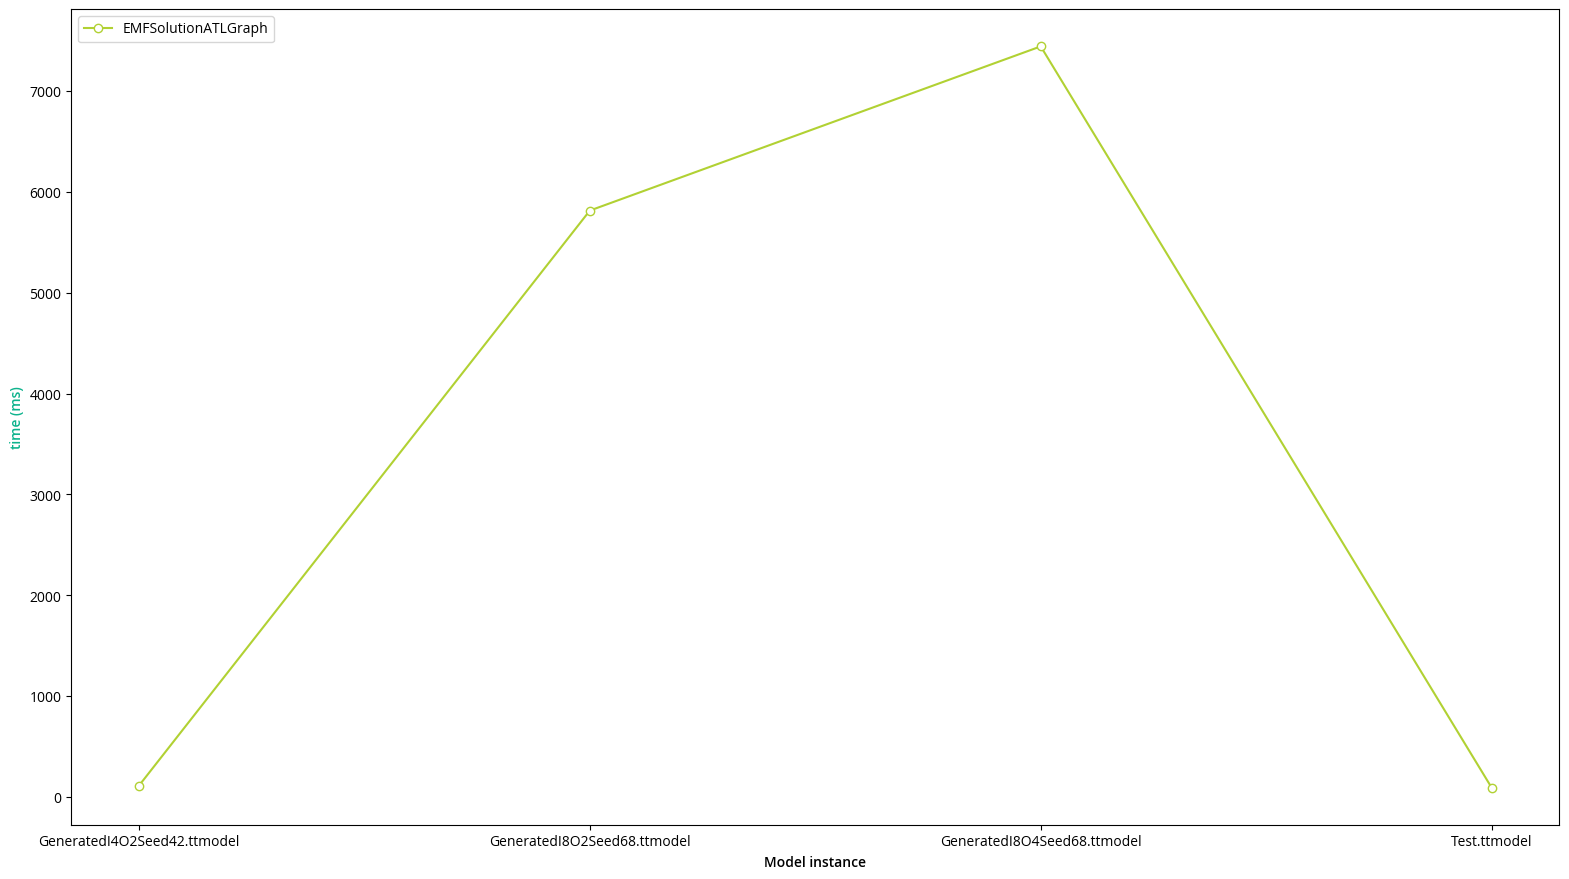

In [93]:
fig = plt.figure(figsize=(1920/my_dpi, 1080/my_dpi), dpi=my_dpi)
ax1 = fig.add_subplot(111)

ax1.set_xlabel('Model instance',weight='semibold',name='Open Sans')
ax1.set_ylabel('time (ms)', color=haec_a,weight='semibold',name='Open Sans')
#ax1.set_xticks(range(320,6401,640), minor=True)
#ax1.set_xticks(range(640,6401,640), minor=False)

#ax2 = ax1.twinx()
#ax2.set_ylabel('quality', color=haec_h,weight='semibold',name='Open Sans')
data = read_measurements('../output/output.csv')

#objective, generationTime, totalTime, data = normalise_data(data, seed_to_plot)
data = normalise_data(data)
#print(data)

#ax1.plot(data['Model'], [1] * len(data), color=haec_h, linestyle='dashed', linewidth=1, alpha=0.5,label='memory consumption')
#ax2.plot(data['Model'], [totalTime] * len(data), color=haec_a, linestyle='dashed', linewidth=1, alpha=0.5,label='total run time')
#ax2.plot(data['Model'], [generationTime] * len(data), color=haec_e, linestyle='dashed', linewidth=1, alpha=0.5,label='unclustered generation time')
first = True
#for run in runs:
#    data_for_tool = data[np.where(data['run'] == run)]
#    if first:
#        ax1.plot(data_for_tool['Model'], data_for_tool['objective'], color=haec_h,label='solution quality',marker='o')
#        ax2.plot(data_for_tool['Model'], data_for_tool['clusteringTime'], color=haec_c, label='clustering time',marker='o', mfc='w')
#        ax2.plot(data_for_tool['Model'], data_for_tool['generationTime'], color=haec_e, label='generation time',marker='o', mfc='w')
#        ax2.plot(data_for_tool['Model'], data_for_tool['solvingTime'], color=haec_a,label='total solving time',marker='o', mfc='w')
#        first = False
#    else:
for tool in np.unique(data['Tool']):
    data_for_tool = data[data['Tool'] == tool]
#    ax1.plot(data_for_tool['Model'], data_for_tool['objective'], color=haec_h,marker='o')
    ax1.plot(data_for_tool['Model'], data_for_tool['MetricValue'], color=haec_c, label=tool, marker='o', mfc='w')
#    ax2.plot(data_for_tool['Model'], data_for_tool['generationTime'], color=haec_e, marker='o', mfc='w')
#    ax2.plot(data_for_tool['Model'], data_for_tool['solvingTime'], color=haec_a,marker='o', mfc='w')

ax1.legend(loc='upper left')
#ax2.legend(loc='upper right')

#ax1.set_ylim(0, 1.19)
#ax2.set_ylim(0, max_time)

fig.savefig('run_time.pdf', format="pdf")
fig.savefig('run_time.png', format="png")